In [2]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
from load_data import load_and_transform_data

In [4]:
X_train, y_train, X_val, y_val, X_test, y_test = load_and_transform_data(SEED=42)

Dataset already exists at: chest_xray_data

Dataset ready at: c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project3_FYSSTK3155-4155\Code\chest_xray_data
Dataset already exists at: chest_xray_data_split



Loading test: 100%|██████████| 587/587 [00:04<00:00, 145.09it/s]

Train: (4684, 480, 480), Val: (585, 480, 480), Test: (587, 480, 480)


In [5]:
# Check shape of subsets
print(f"X train shape:\t", X_train.shape)
print(f"y train shape:\t", y_train.shape)
print(f"X val shape:\t", X_val.shape)
print(f"y val shape:\t", y_val.shape)
print(f"X test shape:\t", X_test.shape)
print(f"y test shape:\t", y_test.shape)

X train shape:	 (4684, 480, 480)
y train shape:	 (4684,)
X val shape:	 (585, 480, 480)
y val shape:	 (585,)
X test shape:	 (587, 480, 480)
y test shape:	 (587,)


In [6]:
batch_size = 32
epochs = 5
n_runs = 10
test_image_idx = 0

# Storage for all runs
all_histories = []
all_test_accs = []
all_test_losses = []
all_predictions = []
all_sensitivities = []
all_specificities = []
all_activations = []

In [7]:
from sklearn.metrics import confusion_matrix

for run in range(n_runs):
    print(f"\n--- Run {run + 1}/{n_runs} ---")
    
    # Clear session and rebuild model for each run
    tf.keras.backend.clear_session()
    
    # Build model
    GRU = keras.Sequential()
    GRU.add(keras.Input(shape=(480, 480)))
    GRU.add(layers.GRU(units=240, return_sequences=True, name='gru1'))
    GRU.add(layers.GRU(units=120, name='gru2'))
    GRU.add(layers.Dense(units=1, activation="sigmoid", name='output'))
    
    # Compile
    GRU.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    # Train
    trainer = GRU.fit(X_train, y_train, validation_data=(X_val, y_val), 
                     batch_size=batch_size, epochs=epochs, verbose=0)
    
    # Evaluate
    test_loss, test_acc = GRU.evaluate(X_test, y_test, verbose=0)
    
    # Store predictions for confusion matrix
    y_pred = GRU.predict(X_test, verbose=0)
    all_predictions.append(y_pred)
    
    # Calculate sensitivity and specificity
    y_pred_class = (y_pred > 0.5).astype(int).flatten()
    cm = confusion_matrix(y_test, y_pred_class)
    tn, fp, fn, tp = cm.ravel()
    
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    # Extract activations using layer directly
    test_image = X_test[test_image_idx:test_image_idx+1]
    
    # Create intermediate model by accessing layers
    gru1_layer = GRU.get_layer('gru1')
    activation_model = keras.Model(inputs=GRU.layers[0].input, outputs=gru1_layer.output)
    
    gru1_output = activation_model.predict(test_image, verbose=0)[0]
    timestep_importance = np.abs(gru1_output).mean(axis=1)
    
    # Store results
    all_histories.append(trainer.history)
    all_test_accs.append(test_acc)
    all_test_losses.append(test_loss)
    all_sensitivities.append(sensitivity)
    all_specificities.append(specificity)
    all_activations.append(timestep_importance)
    
    print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")
    print(f"Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")


--- Run 1/10 ---

Test Accuracy: 0.9250, Test Loss: 0.1885
Sensitivity: 0.9276, Specificity: 0.9182

--- Run 2/10 ---
Test Accuracy: 0.9114, Test Loss: 0.2126
Sensitivity: 0.9206, Specificity: 0.8868

--- Run 3/10 ---
Test Accuracy: 0.9233, Test Loss: 0.2032
Sensitivity: 0.9439, Specificity: 0.8679

--- Run 4/10 ---
Test Accuracy: 0.9302, Test Loss: 0.1918
Sensitivity: 0.9369, Specificity: 0.9119

--- Run 5/10 ---
Test Accuracy: 0.9216, Test Loss: 0.1880
Sensitivity: 0.9393, Specificity: 0.8742

--- Run 6/10 ---


KeyboardInterrupt: 

In [8]:
# Compute mean test metrics
mean_test_acc = np.mean(all_test_accs)
mean_test_loss = np.mean(all_test_losses)
mean_sensitivity = np.mean(all_sensitivities)
mean_specificity = np.mean(all_specificities)
mean_train_acc = np.mean([h['accuracy'] for h in all_histories], axis=0)
mean_val_acc = np.mean([h['val_accuracy'] for h in all_histories], axis=0)
mean_train_loss = np.mean([h['loss'] for h in all_histories], axis=0)
mean_val_loss = np.mean([h['val_loss'] for h in all_histories], axis=0)

print(f"\n=== Final Results Over {n_runs} Runs ===")
print(f"Test Accuracy: {mean_test_acc:.4f}")
print(f"Test Loss: {mean_test_loss:.4f}")
print(f"Sensitivity: {mean_sensitivity:.4f}")
print(f"Specificity: {mean_specificity:.4f}")

# Average the histories across all runs
max_epochs = max(len(h['accuracy']) for h in all_histories)

mean_train_acc = [np.mean([h['accuracy'][e] for h in all_histories if len(h['accuracy']) > e]) 
                  for e in range(max_epochs)]
mean_val_acc = [np.mean([h['val_accuracy'][e] for h in all_histories if len(h['val_accuracy']) > e]) 
                for e in range(max_epochs)]
mean_train_loss = [np.mean([h['loss'][e] for h in all_histories if len(h['loss']) > e]) 
                   for e in range(max_epochs)]
mean_val_loss = [np.mean([h['val_loss'][e] for h in all_histories if len(h['val_loss']) > e]) 
                 for e in range(max_epochs)]



=== Final Results Over 10 Runs ===
Test Accuracy: 0.9223
Test Loss: 0.1968
Sensitivity: 0.9336
Specificity: 0.8918


### Plotting results

In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# Widths in inches from revtex4's layout
columnwidth = 4.375
fig_width = columnwidth
fig_height = columnwidth / 1.618
fig_size = [fig_width, fig_height]

mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": [],
    "font.size": 14.0, 
    "axes.labelsize": 14.0,
    "legend.fontsize": 12.0,
    "xtick.labelsize": 12.0,
    "ytick.labelsize": 12.0,
    "figure.figsize": fig_size,
    "savefig.dpi": 300,
})


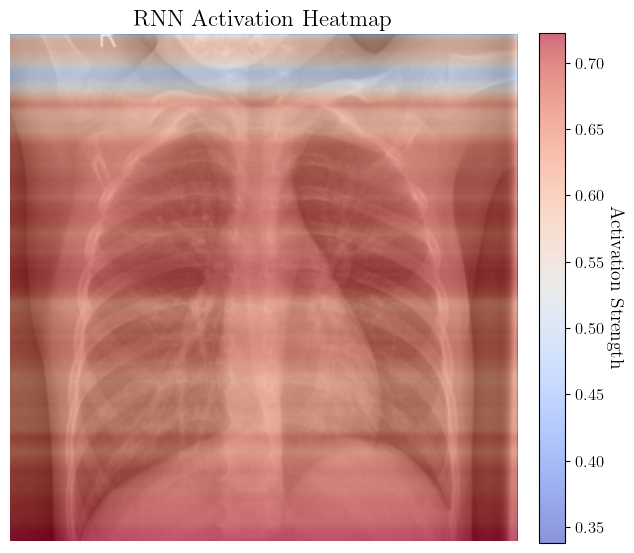

In [10]:
# RNN Activation Heatmap
fig_size_square = [columnwidth * 1.5, columnwidth * 1.5]
fig, ax = plt.subplots(figsize=fig_size_square)

mean_activation = np.mean(all_activations, axis=0)
test_image = X_test[test_image_idx]

ax.imshow(test_image, cmap='gray')
heatmap = ax.imshow(mean_activation.reshape(-1, 1).repeat(480, axis=1), 
                    cmap='coolwarm', alpha=0.6, vmin=mean_activation.min(), 
                    vmax=mean_activation.max())

ax.set_title(f'RNN Activation Heatmap')
ax.axis('off')

cbar = plt.colorbar(heatmap, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Activation Strength', rotation=270, labelpad=15)

plt.tight_layout()
plt.savefig('gru_activation_heatmap.pdf', bbox_inches='tight')
plt.show()

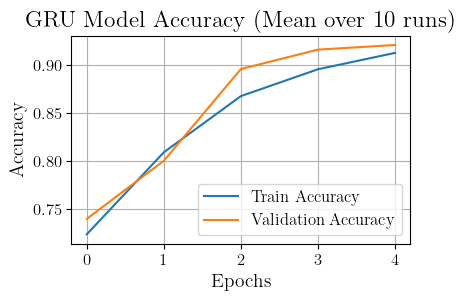

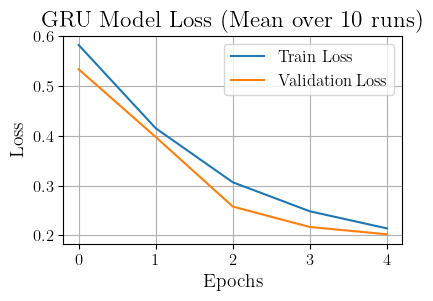

In [11]:
plt.figure()
plt.plot(mean_train_acc, label='Train Accuracy')
plt.plot(mean_val_acc, label='Validation Accuracy')  # Changed from test
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title(f'GRU Model Accuracy (Mean over {n_runs} runs)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(mean_train_loss, label='Train Loss')
plt.plot(mean_val_loss, label='Validation Loss')  # Changed from test
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'GRU Model Loss (Mean over {n_runs} runs)')
plt.legend()
plt.grid(True)
plt.show()

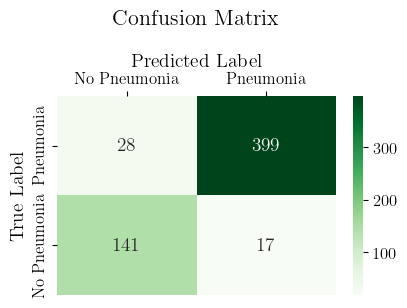

In [19]:
import seaborn as sns

# Compute mean confusion matrix across all runs
all_cms = []
for y_pred in all_predictions:
    y_pred_classes = (y_pred > 0.5).astype(int).flatten()
    cm = confusion_matrix(y_test, y_pred_classes)
    all_cms.append(cm)

mean_cm = np.mean(all_cms, axis=0).astype(int)
mean_cm_flipped = np.flipud(mean_cm)

fig, ax = plt.subplots(figsize=(columnwidth, columnwidth*(3/4)))
sns.heatmap(mean_cm_flipped, annot=True, fmt='d', ax=ax, cmap="Greens", 
            yticklabels=['Pneumonia', 'No Pneumonia'],
            xticklabels=['No Pneumonia', 'Pneumonia'])
ax.set_title(f"Confusion Matrix", 
             fontsize=16, pad=20)

ax.set_xlabel("Predicted Label", fontsize=14)
ax.set_ylabel("True Label", fontsize=14)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.show()

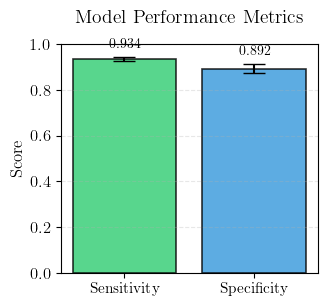

In [20]:
# Plot 1: Sensitivity and Specificity as bar chart
fig, ax = plt.subplots(figsize=(columnwidth*0.8, columnwidth*(3/4)))

metrics = ['Sensitivity', 'Specificity']
values = [mean_sensitivity, mean_specificity]
std_values = [np.std(all_sensitivities), np.std(all_specificities)]

x_pos = np.arange(len(metrics))
bars = ax.bar(x_pos, values, yerr=std_values, capsize=8, 
               color=['#2ecc71', '#3498db'], alpha=0.8, edgecolor='black', linewidth=1.2)

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Metrics', fontsize=14, pad=15)
ax.set_xticks(x_pos)
ax.set_xticklabels(metrics, fontsize=11)
ax.set_ylim([0, 1])
ax.grid(True, alpha=0.3, axis='y', linestyle='--')

for i, (val, std) in enumerate(zip(values, std_values)):
    ax.text(i, val + std + 0.03, f'{val:.3f}', 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

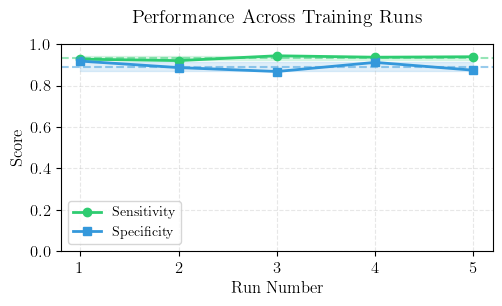

In [22]:
# Plot 2: Sensitivity and Specificity across runs
fig, ax = plt.subplots(figsize=(columnwidth*1.2, columnwidth*(3/4)))

actual_runs = len(all_sensitivities)
runs = np.arange(1, actual_runs + 1)

ax.plot(runs, all_sensitivities, marker='o', label='Sensitivity', 
        linewidth=2, markersize=6, color='#2ecc71')
ax.plot(runs, all_specificities, marker='s', label='Specificity', 
        linewidth=2, markersize=6, color='#3498db')

ax.axhline(y=mean_sensitivity, color='#2ecc71', linestyle='--', alpha=0.5, linewidth=1.5)
ax.axhline(y=mean_specificity, color='#3498db', linestyle='--', alpha=0.5, linewidth=1.5)

ax.fill_between(runs, 
                mean_sensitivity - np.std(all_sensitivities), 
                mean_sensitivity + np.std(all_sensitivities), 
                alpha=0.15, color='#2ecc71')
ax.fill_between(runs, 
                mean_specificity - np.std(all_specificities), 
                mean_specificity + np.std(all_specificities), 
                alpha=0.15, color='#3498db')

ax.set_xlabel('Run Number', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Performance Across Training Runs', fontsize=14, pad=15)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_ylim([0, 1])
ax.set_xticks(runs)

plt.tight_layout()
plt.show()